In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib.ticker import MultipleLocator

import pickle
from magpie_data import NeLMap, Interferogram
import os

# Interferometry

### How to use this template

This template is both a tutorial and a repository of useful code blocks. In it you will find out how to:
* Plot raw interferograms
* Assign a scale, origin and region of interest
* Plot electron density maps
* Take lineouts
* Annotate using circles and text
* Create images with multiple plots

We will start with the raw interferograms

#### 1. Folder where data is stored
On Windows, you can shift+right-click a folder and choose "Copy as Path". Here we use the data in the example folder of this repo.

In [2]:
%cd "example_data"

C:\Users\JHARE\Documents\GitHub\magpie_tools\templates\example_data


#### 2. Filenames
Load a raw interferogram. This uses the example data from s1006_15, which is end on interferometry at 532 nm.

I recommend opening a pre-shot shadow image in Photoshop. 

First determine if the image needs to be flipped. This is useful for diagnostics which share an imaging path and use a beamsplitter: for example, the 532 nm/ 355 nm interferometry, or the interferometry and the fast frame camera. Use flip_lr = True to flip around a vertical line running through the centre of the image. In this example, we don't flip, but we will use it later for the 355 nm. Perform the flip in photoshop, so you can use that image to determine rotation and origin.

Secondly, determine the rotation. Here you can use a straight edge in your hardware and the photoshop ruler tool to determine the rotation angle that rotates the image onto your desired coordinate system. For example, here the image is rotated by -90 (or 90 clockwise) so that X is the horizontal and Y is the vertical axis. You may need to rotate by eg -91 to account for a slight misalignment. Rotate the image in photoshop as well.

You can also determine the scale in Photoshop - pick two points which you know the separation between in mm, say from a CAD model, and measure the separation in pixels. Then set the scale as pixels per mm.

In [3]:
fn = 's1006_15 532nm end on interferometry levels.JPG'
rot = -90
scale = 173
s1006_15_532_if = Interferogram(fn, scale=scale, rot_angle=rot, flip_lr=False) #this creates an interferogram object
s = s1006_15_532_if #we use s as a shortcut

fig, ax = plt.subplots(figsize=(6,8))
s.plot_data_px(ax=ax) # the DataMap object provides a function to plot the raw data, which is inherited by Interferogram
fig.tight_layout()

<IPython.core.display.Javascript object>

#### 3. Set origin and extent

IMPORTANT NOTE: To ensure consistency with matplotlib and arrays, we use (vertical, horizontal) as the coordinate system, where the pixel origin is in the top left of the image. This is in contrast the usual physics convention of (horizontal, vertical) and an origin in the bottom right. Fortunately, Photoshop uses the same origin convention, which helps a lot.

Using photoshop on your (flipped and) rotated image, choose the origin of your image in pixel coordinates. This will be the origin (0,0) of the image in physical coordinates (eg mm). You may need to use the ruler tool and several points to determine this - for the reconnection hardware in our example, I have two parallel straight edges, and I take the average of several measurements to determine x and y. You could try and work out the origin using the figure above as well, at least as a check!

Then determine how much of the original image you want to keep, in mm. This can take a bit of trial and error, as if you select a region which is out of bounds, the code currently does some odd things. Use verbose  = True to check the pixels you are asking for are inside the array.

In [4]:
s.set_origin(origin=(2305,1411), extent=[-11.5,11.5,-8,8], verbose = True)

fig, ax = plt.subplots(figsize=(6,8))
s.plot_data_mm(ax=ax) # the DataMap object provides a function to plot the cropped data, which is inherited by Interferogram

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title('Raw interferogram from '+s.fn)

fig.tight_layout()

ymin, ymax, xmin, xmax: 
315 4294 27 2795
Limits in y and x:
(4752, 3168, 3)


<IPython.core.display.Javascript object>

#### 4. Electron density maps

IMPORTANT NOTE: First unzip s1006_15 532nm neL.zip into the example_data folder.

Now we use all of the image rotation etc for the electron density map. The arguments are the same as used for the interferometry, but we also have multiply_by, which can be used to convert $n_e L$ into $n_e$ by dividing by some length scale L, which here is 1.6 cm.

In [5]:
fn = 's1006_15 532nm neL.txt'
s1006_15_532=NeLMap(fn, scale=scale, rot_angle=rot, flip_lr = False,  multiply_by=1/1.6)
s = s1006_15_532 #we use s as a shortcut

fig, ax = plt.subplots(figsize=(6,8))
s.plot_data_px(ax=ax) # the DataMap object provides a function to plot the raw data, which is inherited by Interferogram
fig.tight_layout()

<IPython.core.display.Javascript object>

Now we simply copy the same origin and extent over and use them here.

For plotting, we can scale by 1e-18 so that the colour bar looks nice, and set the limits using clim. Note that the scaling in s.plot_data_mm does not alter the data.

In [6]:
s.set_origin(origin=(2305,1411), extent=[-11.5,11.5,-8,8], verbose = True)

fig, ax = plt.subplots(figsize=(6,8))
im = s.plot_data_mm(ax=ax, multiply_by = 1e-18, clim=[0,2])

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title('Electron density map from '+s.fn)

ax_divider = make_axes_locatable(ax)
# add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="2%", pad="1%")
cb = colorbar(im, cax=cax, ticks=[0,1 ,2])
cb.set_label_text(r'$n_e$ ($\times$ 10$^{18}$ cm$^{-3}$)',fontsize=10)
cb.ax.tick_params(labelsize=10, pad=5, length=6, width=1, direction = 'in')

#fig.tight_layout()

ymin, ymax, xmin, xmax: 
315 4294 27 2795
Limits in y and x:
(4752, 3168)


<IPython.core.display.Javascript object>

#### 5. Diptych
It can be interesting to plot the raw interferogram and the electron density map side by side:

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), sharex = True, sharey = True)

s1006_15_532_if.plot_data_mm(ax=ax1) # the DataMap object provides a function to plot the cropped data, which is inherited by Interferogram

ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')
ax1.set_title('Raw interferogram from '+s.fn, fontsize=10)

im = s1006_15_532.plot_data_mm(ax=ax2, multiply_by = 1e-18, clim=[0,2])

ax2.set_xlabel('x [mm]')

ax2.set_title('Electron density map from '+s.fn, fontsize=10)

ax_divider = make_axes_locatable(ax2)
# add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="4%", pad="1%")
cb = colorbar(im, cax=cax, ticks=[0,1 ,2])
cb.set_label_text(r'$n_e$ ($\times$ 10$^{18}$ cm$^{-3}$)',fontsize=10)
cb.ax.tick_params(labelsize=10, pad=5, length=6, width=1, direction = 'in')


<IPython.core.display.Javascript object>

#### 6. Annotations

It can be helpful to add annotations, for example text, and the locations of wires and Thomson scattering volumes. The following shows how to do this with several examples. We start with the diptych above.

<IPython.core.display.Javascript object>


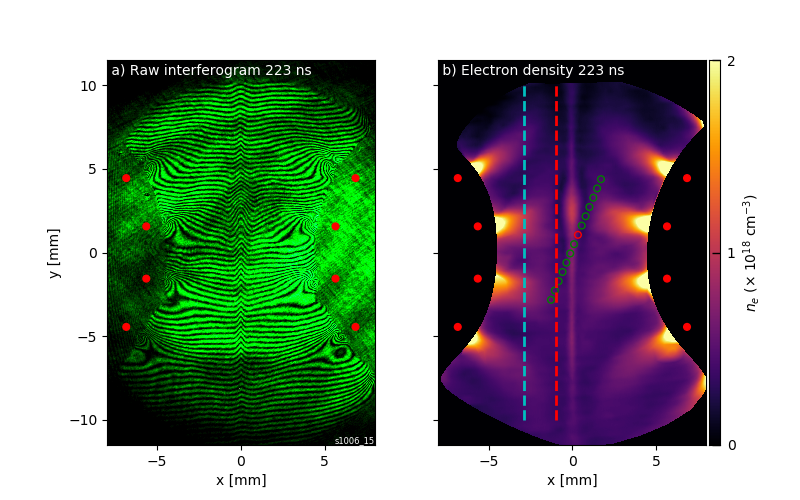

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), sharex = True, sharey = True)

s1006_15_532_if.plot_data_mm(ax=ax1) # the DataMap object provides a function to plot the cropped data, which is inherited by Interferogram

ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')

im = s1006_15_532.plot_data_mm(ax=ax2, multiply_by = 1e-18, clim=[0,2])

ax2.set_xlabel('x [mm]')


ax_divider = make_axes_locatable(ax2)
# add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="4%", pad="1%")
cb = colorbar(im, cax=cax, ticks=[0,1 ,2])
cb.set_label_text(r'$n_e$ ($\times$ 10$^{18}$ cm$^{-3}$)',fontsize=10)
cb.ax.tick_params(labelsize=10, pad=5, length=6, width=1, direction = 'in')

##### Annotations #####

#### Wire Locations

th=np.linspace(-360/32*3,360/32*3,4) # angles
for t in th:
    for a in (ax1, ax2):
        c= plt.Circle((-13.5+8*np.cos(t*np.pi/180),8*np.sin(t*np.pi/180)), 0.2, color='r')
        a.add_artist(c)
        c= plt.Circle((13.5-8*np.cos(t*np.pi/180),8*np.sin(t*np.pi/180)), 0.2, color='r')
        a.add_artist(c)
        
#### Text        
ax1.text(x=0.0, y=0.99, va='top',ha='left',s=r' a) Raw interferogram 223 ns', color='white',fontsize=10, transform=ax1.transAxes)
ax2.text(x=0.0, y=0.99, va='top',ha='left',s=r' b) Electron density 223 ns', color='white',fontsize=10,transform=ax2.transAxes)

ax1.text(x=1, y=0.0, va='bottom',ha='right',s=r's1006_15', color='white',fontsize=6,transform=ax1.transAxes)

#### Thomson scattering

angle = 22.5 * np.pi/180 #degrees to vertical
spacing = 0.6 #space between fibres in mm
spot_size = 0.2 #spot size in mm, set by fibres and laser beam - really this should be not a circle!
f7 = (0.5, 0.1) #location of fibre 7 in mm
fx = [f7[1] - i*spacing*np.sin(angle) for i in range(-7,7)]
fy = [f7[0] - i*spacing*np.cos(angle) for i in range(-7,7)]

for i in range(0,14):
    color = 'g'
    if i == 6: #color fibre 7 for easy spotting
        color = 'r'
    c= plt.Circle((fx[i],fy[i]), spot_size, edgecolor = color, fill = False)
    ax2.add_artist(c)
    
#### Lines

for x_mm in [-2.9,-1]:
    ax2.plot([x_mm,x_mm],[-10,10], lw=2, ls='dashed')
ax2.lines[0].set_color('c')
ax2.lines[1].set_color('red')

#### 7. Lineouts
You can create lineouts to get a quantitative feel for how the electron density changes.

This default example takes a lineout along a line of constant x. Start is the coordinates in mm of the start point (y,x), end is the coordinates in mm of the end point, and the lineout_width is the width in mm. Note that the width is the total width of lineout, so a lineout of width w averages over -w/2 to + w/2 around the line.

Creating a lineout results in two new properties of s: the linout, lo, and the scale, mm. Note that the scale is centered around the mid-point of the line by default (so runs from -line_length/2 to line_length_2). this may not be appropriate for your lineouts, so remember to shift s.mm of create a new array which represents your lineout.

Changing this to a lineout along some arbitrary direction, simply change start and end - and be careful with what s.mm really represents!

<IPython.core.display.Javascript object>


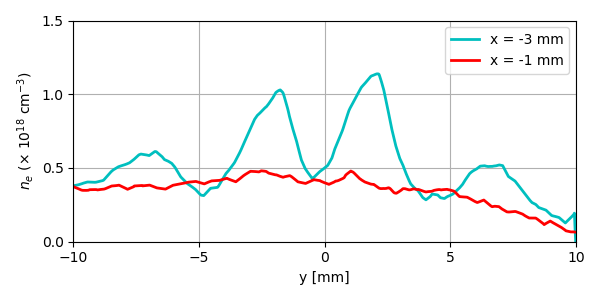

In [12]:
fig, ax = plt.subplots(figsize=(6, 3), sharey=True)    

w = 0.1

x_mm = -3
s  =s1006_15_532
s.create_lineout(start = (-10, x_mm), end = (10, x_mm), lineout_width_mm = w)
ax.plot(s.mm, s.lo*1e-18, label="x = "+str(x_mm)+" mm", lw=2, c='c')  

x_mm = -1
s.create_lineout(start = (-10, x_mm), end = (10, x_mm), lineout_width_mm = w)
ax.plot(s.mm, s.lo*1e-18, label="x = "+str(x_mm)+" mm", lw=2, c='red') 

ax.set_xlabel('y [mm]', fontsize=10)
ax.set_xlim([-10,10])
ax.set_xticks([-10,-5,0,5,10])
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.set_ylim([0,1.5])
ax.set_yticks([0,0.5,1,1.5])
ax.set_ylabel(r'$n_e$ ($\times$ 10$^{18}$ cm$^{-3}$)', fontsize=10)

ax.grid()
ax.legend()

fig.tight_layout()

#### 8. Save Figures
You can save any figure using the code below.  For lines, I suggest .pdf, and for images I suggest .png.

In [10]:
folder=r'~\some\folder\in\your\home\directory\like\Downloads'
fn=s.fn[:8]+' lineouts.png'
p=os.path.expanduser(os.path.join(folder,fn))
fig.savefig(p, dpi=600)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\JHARE\\some\\folder\\in\\your\\home\\directory\\like\\Downloads\\s1006_15 lineouts.png'

#### 9. Extracting data

Say, for example, you want to find the electron density at a set of points, for entry in Thomson scattering. This is a simple example of how to use mm_to_px, which selects only a single pixel. In some cases, you may wish to use a range of pixels to calculate the average density.

In [11]:
#### Thomson scattering - using the same made up fibre locations as before

angle = 22.5 * np.pi/180 #degrees to vertical
spacing = 0.6 #space between fibres in mm
f7 = (0.5, 0.1) #location of fibre 7 in mm
fx = [f7[1] - i*spacing*np.sin(angle) for i in range(-7,7)]
fy = [f7[0] - i*spacing*np.cos(angle) for i in range(-7,7)]

n_e = []

for x, y in zip(fx, fy):
    px = s.mm_to_px((y, x)) # here we use the (vertical, horizontal) convention
    n_e_at_px = s.data_c[px]
    n_e.append(n_e_at_px)
    
print(n_e)

[4.537187499999996e+17, 4.2436874999999974e+17, 4.7521249999999994e+17, 4.1246249999999994e+17, 3.6189374999999936e+17, 4.090062499999999e+17, 4.782000000000012e+17, 6.92075000000001e+17, 6.491249999999986e+17, 4.1656874999999885e+17, 3.962e+17, 4.063062500000004e+17, 4.7860625e+17, 5.2073750000000064e+17]
